# **Veri Çekme**

In [ ]:
!pip install tqdm

In [ ]:
import requests
import time
import json
from tqdm.notebook import tqdm

API_KEY = "RGAPI-aaf60011-2c11-47e3-a64e-5e22cdfeba53"

SERVER = "euw1"
REGION = "europe"
TIER = "MASTER"
DIVISION = "IV"

headers = {"X-Riot-Token": API_KEY}

def get_players_from_league(tier, division, server, count=5):
    if tier in ["MASTER", "GRANDMASTER", "CHALLENGER"]:
        url = f"https://{server}.api.riotgames.com/lol/league/v4/{tier.lower()}leagues"
    else:
        url = f"https://{server}.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/{tier}/{division}?page=1"

    resp = requests.get(url, headers=headers)
    if resp.status_code != 200:
        return []

    players = resp.json()
    if tier in ["MASTER", "GRANDMASTER", "CHALLENGER"]:
        players = players.get("entries", [])

    return players[:count]

def filter_participant_data(participant, opponent_champion):
    perks = participant.get("perks", {})
    stat = perks.get("statPerks", {})
    styles = perks.get("styles", [])

    def clean_style(style):
        return {
            "styleId": style.get("style"),
            "description": style.get("description"),
            "perks": [s.get("perk") for s in style.get("selections", [])]
        }

    return {
        "puuid": participant.get("puuid"),
        "championId": participant.get("championId"),
        "championName": participant.get("championName"),
        "teamId": participant.get("teamId"),
        "teamPosition": participant.get("teamPosition"),
        "individualPosition": participant.get("individualPosition"),
        "kills": participant.get("kills"),
        "deaths": participant.get("deaths"),
        "assists": participant.get("assists"),
        "goldEarned": participant.get("goldEarned"),
        "goldSpent": participant.get("goldSpent"),
        "item0": participant.get("item0"),
        "item1": participant.get("item1"),
        "item2": participant.get("item2"),
        "item3": participant.get("item3"),
        "item4": participant.get("item4"),
        "item5": participant.get("item5"),
        "item6": participant.get("item6"),
        "perks": {
            "statPerks": {
                "offense": stat.get("offense"),
                "flex": stat.get("flex"),
                "defense": stat.get("defense")
            },
            "styles": [clean_style(s) for s in styles]
        },
        "challenges": {
            "abilityUses": participant.get("challenges", {}).get("abilityUses"),
            "damagePerMinute": participant.get("challenges", {}).get("damagePerMinute"),
            "damageTakenOnTeamPercentage": participant.get("challenges", {}).get("damageTakenOnTeamPercentage"),
            "firstTurretKilled": participant.get("challenges", {}).get("firstTurretKilled"),
            "goldPerMinute": participant.get("challenges", {}).get("goldPerMinute"),
            "kda": participant.get("challenges", {}).get("kda"),
            "killParticipation": participant.get("challenges", {}).get("killParticipation"),
            "laneMinionsFirst10Minutes": participant.get("challenges", {}).get("laneMinionsFirst10Minutes"),
            "laningPhaseGoldExpAdvantage": participant.get("challenges", {}).get("laningPhaseGoldExpAdvantage"),
            "legendaryItemUsed": participant.get("challenges", {}).get("legendaryItemUsed"),
            "maxCsAdvantageOnLaneOpponent": participant.get("challenges", {}).get("maxCsAdvantageOnLaneOpponent"),
            "soloKills": participant.get("challenges", {}).get("soloKills")
        },
        "win": participant.get("win"),
        "opponentChampion": opponent_champion
    }

def get_last_ranked_matches_of_player(puuid, server_region, count=1):
    url_ids = (
        f"https://{server_region}.api.riotgames.com"
        f"/lol/match/v5/matches/by-puuid/{puuid}/ids"
        f"?start=0&count={count}&queue=420"
    )
    resp = requests.get(url_ids, headers=headers)
    if resp.status_code != 200:
        return []

    match_ids = resp.json()
    filtered_matches = []

    for mid in match_ids:
        try:
            resp = requests.get(
                f"https://{server_region}.api.riotgames.com/lol/match/v5/matches/{mid}",
                headers=headers
            )
            if resp.status_code != 200:
                continue

            data = resp.json()
            parts = data["info"]["participants"]

            lookup = {(p["individualPosition"], p["teamId"]): p["championName"] for p in parts}

            fps = []
            for p in parts:
                opp_team = 200 if p["teamId"] == 100 else 100
                key = (p["individualPosition"], opp_team)
                opponent = lookup.get(key)
                fps.append(filter_participant_data(p, opponent))

            filtered_matches.append({
                "matchId": data["metadata"]["matchId"],
                "participants": fps
            })
            time.sleep(1.2)
        except Exception:
            continue

    return filtered_matches

# === Çalıştırma ===
players = get_players_from_league(TIER, DIVISION, SERVER, count=100) #count kaç oyuncu çekileceğinin bilgisi
all_matches = []
for pl in tqdm(players, desc="Oyuncular için maç verisi çekiliyor"):
    all_matches.extend(
        get_last_ranked_matches_of_player(pl["puuid"], REGION, count=50) #count oyuncu başına kaç maç çekiliceğinin bilgisi
    )

if TIER in ["MASTER", "GRANDMASTER", "CHALLENGER"]:
    file_prefix = f"{TIER}_"
else:
    file_prefix = f"{TIER}_{DIVISION}_"

# JSON dosyalarına kaydet
with open(f"{file_prefix}PLAYERS.json", "w") as f1:
    json.dump(players, f1, indent=4)

with open(f"{file_prefix}MATCHES.json", "w") as f2:
    json.dump(all_matches, f2, indent=4)

print("Veriler kaydedildi.")

# Verileri **Birleştirme**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import csv

file_paths = [
    "/content/drive/MyDrive/data/bronze/matches/BRONZE_III_MATCHES",
    "/content/drive/MyDrive/data/bronze/matches/BRONZE_II_MATCHES",
    "/content/drive/MyDrive/data/bronze/matches/BRONZE_IV_MATCHES",
    "/content/drive/MyDrive/data/bronze/matches/BRONZE_I_MATCHES",
    "/content/drive/MyDrive/data/diamond/matches/DIAMOND_III_MATCHES",
    "/content/drive/MyDrive/data/diamond/matches/DIAMOND_II_MATCHES",
    "/content/drive/MyDrive/data/diamond/matches/DIAMOND_IV_MATCHES",
    "/content/drive/MyDrive/data/diamond/matches/DIAMOND_I_MATCHES",
    "/content/drive/MyDrive/data/emerald/matches/EMERALD_III_MATCHES",
    "/content/drive/MyDrive/data/emerald/matches/EMERALD_II_MATCHES",
    "/content/drive/MyDrive/data/emerald/matches/EMERALD_IV_MATCHES",
    "/content/drive/MyDrive/data/emerald/matches/EMERALD_I_MATCHES",
    "/content/drive/MyDrive/data/gold/matches/GOLD_III_MATCHES",
    "/content/drive/MyDrive/data/gold/matches/GOLD_II_MATCHES",
    "/content/drive/MyDrive/data/gold/matches/GOLD_IV_MATCHES",
    "/content/drive/MyDrive/data/gold/matches/GOLD_I_MATCHES",
    "/content/drive/MyDrive/data/iron/matches/IRON_III_MATCHES",
    "/content/drive/MyDrive/data/iron/matches/IRON_II_MATCHES",
    "/content/drive/MyDrive/data/iron/matches/IRON_IV_MATCHES",
    "/content/drive/MyDrive/data/iron/matches/IRON_I_MATCHES",
    "/content/drive/MyDrive/data/plat/matches/PLATINUM_III_MATCHES",
    "/content/drive/MyDrive/data/plat/matches/PLATINUM_II_MATCHES",
    "/content/drive/MyDrive/data/plat/matches/PLATINUM_IV_MATCHES",
    "/content/drive/MyDrive/data/plat/matches/PLATINUM_I_MATCHES",
    "/content/drive/MyDrive/data/silver/matches/SILVER_III_MATCHES",
    "/content/drive/MyDrive/data/silver/matches/SILVER_II_MATCHES",
    "/content/drive/MyDrive/data/silver/matches/SILVER_IV_MATCHES",
    "/content/drive/MyDrive/data/silver/matches/SILVER_I_MATCHES",
]

FIELDS = [
    "tier",
    "championName",
    "individualPosition",
    "kills", "deaths", "assists",
    "goldEarned", "goldSpent",
    "item0", "item1", "item2", "item3", "item4", "item5", "item6",
    "offense", "flex", "defense",
    "perk1", "perk2", "perk3", "perk4", "perk5", "perk6",
    "abilityUses", "damagePerMinute", "firstTurretKilled",
    "goldPerMinute", "kda", "laneMinionsFirst10Minutes",
    "soloKills", "opponentChampion", "win"
]

def extract_participant(p, tier):
    stat = p["perks"]["statPerks"]
    styles = p["perks"]["styles"]
    primary_perks = styles[0].get("perks", [])
    sub_perks     = styles[1].get("perks", [])

    perks_flat = []
    for i in range(4):
        perks_flat.append(primary_perks[i] if i < len(primary_perks) else "")
    for i in range(2):
        perks_flat.append(sub_perks[i]     if i < len(sub_perks)     else "")

    chal = p.get("challenges", {})

    return {
        "tier": tier,
        "championName":       p.get("championName", ""),
        "individualPosition": p.get("individualPosition", ""),
        "kills":              p.get("kills", 0),
        "deaths":             p.get("deaths", 0),
        "assists":            p.get("assists", 0),
        "goldEarned":         p.get("goldEarned", 0),
        "goldSpent":          p.get("goldSpent", 0),
        "item0":              p.get("item0", 0),
        "item1":              p.get("item1", 0),
        "item2":              p.get("item2", 0),
        "item3":              p.get("item3", 0),
        "item4":              p.get("item4", 0),
        "item5":              p.get("item5", 0),
        "item6":              p.get("item6", 0),
        "offense":            stat.get("offense", 0),
        "flex":               stat.get("flex", 0),
        "defense":            stat.get("defense", 0),
        "perk1":              perks_flat[0],
        "perk2":              perks_flat[1],
        "perk3":              perks_flat[2],
        "perk4":              perks_flat[3],
        "perk5":              perks_flat[4],
        "perk6":              perks_flat[5],
        "abilityUses":        chal.get("abilityUses", ""),
        "damagePerMinute":    chal.get("damagePerMinute", ""),
        "firstTurretKilled":  chal.get("firstTurretKilled", ""),
        "goldPerMinute":      chal.get("goldPerMinute", ""),
        "kda":                chal.get("kda", ""),
        "laneMinionsFirst10Minutes": chal.get("laneMinionsFirst10Minutes", ""),
        "soloKills":          chal.get("soloKills", ""),
        "opponentChampion":   p.get("opponentChampion", ""),
        "win":                p.get("win", "")
    }

all_rows = []
for path in file_paths:
    tier = os.path.basename(path).split("_")[0].lower()
    with open(path, "r", encoding="utf8") as f:
        matches = json.load(f)
    for match in matches:
        for p in match["participants"]:
            all_rows.append(extract_participant(p, tier))

with open("ALL_TIERS_FULL_PARTICIPANTS.csv", "w", newline="", encoding="utf8") as out:
    writer = csv.DictWriter(out, fieldnames=FIELDS)
    writer.writeheader()
    writer.writerows(all_rows)

print(f"Birleştirildi: {len(all_rows)} kayıt → ALL_TIERS_FULL_PARTICIPANTS.csv")


Birleştirildi: 1325480 kayıt → ALL_TIERS_FULL_PARTICIPANTS.csv


In [ ]:
import pandas as pd

item_map = {
    0:"none", 1001: "Boots", 1004: "Faerie Charm", 1006: "Rejuvenation Bead", 1011: "Giant's Belt", 1018: "Cloak of Agility", 1026: "Blasting Wand", 1027: "Sapphire Crystal",
    1028: "Ruby Crystal", 1029: "Cloth Armor", 1031: "Chain Vest", 1033: "Null-Magic Mantle", 1035: "Emberknife", 1036: "Long Sword", 1037: "Pickaxe", 1038: "B. F. Sword",
    1039: "Hailblade", 1040: "Obsidian Edge", 1042: "Dagger", 1043: "Recurve Bow", 1052: "Amplifying Tome", 1053: "Vampiric Scepter", 1054: "Doran's Shield",
    1055: "Doran's Blade", 1056: "Doran's Ring", 1057: "Negatron Cloak", 1058: "Needlessly Large Rod", 1082: "Dark Seal", 1083: "Cull", 1101: "Scorchclaw Pup",
    1102: "Gustwalker Hatchling", 1103: "Mosstomper Seedling", 1104: "Eye of the Herald", 1105: "Mosstomper Seedling", 1106: "Gustwalker Hatchling",
    1107: "Scorchclaw Pup", 126697: "Hubris", 1500: "Penetrating Bullets", 1501: "Fortification", 1502: "Reinforced Armor", 1503: "Warden's Eye", 1504: "Vanguard",
    1506: "Reinforced Armor", 1507: "Overcharged", 1508: "Anti-tower Socks", 1509: "Gusto", 1510: "Phreakish Gusto", 1511: "Super Mech Armor",
    1512: "Super Mech Power Field", 1515: "Turret Plating", 1516: "Structure Bounty", 1517: "Structure Bounty", 1518: "Structure Bounty", 1519: "Structure Bounty",
    1520: "OvererchargedHA", 1521: "Fortification", 1522: "Tower Power-Up", 1523: "Overcharged", 2003: "Health Potion", 2010: "Total Biscuit of Everlasting Will",
    2015: "Kircheis Shard", 2019: "Steel Sigil", 2020: "The Brutalizer", 2021: "Tunneler", 2022: "Glowing Mote", 2031: "Refillable Potion", 2033: "Corrupting Potion",
    2049: "Guardian's Amulet", 2050: "Guardian's Shroud", 2051: "Guardian's Horn", 2052: "Poro-Snax", 2055: "Control Ward", 2056: "Stealth Ward",
    2065: "Shurelya's Battlesong", 2138: "Elixir of Iron", 2139: "Elixir of Sorcery", 2140: "Elixir of Wrath", 2141: "Cappa Juice", 2142: "Juice of Power",
    2143: "Juice of Vitality", 2144: "Juice of Haste", 2145: "Lucky Dice", 2146: "Enhanced Lucky Dice", 2150: "Elixir of Skill", 2151: "Elixir of Avarice",
    2152: "Elixir of Force", 220000: "Stat Bonus", 220001: "Legendary Fighter Item", 220002: "Legendary Marksman Item", 220003: "Legendary Assassin Item", 2403: "Minion Dematerializer",
    2420: "Seeker's Armguard", 2421: "Shattered Armguard", 2422: "Slightly Magical Footwear", 2501: "Overlord's Bloodmail", 2502: "Unending Despair", 2503: "Blackfire Torch",
    2504: "Kaenic Rookern", 2508: "Fated Ashes", 3001: "Evenshroud", 3002: "Trailblazer", 3003: "Archangel's Staff", 3004: "Manamune", 3005: "Ghostcrawlers",
    3006: "Berserker's Greaves", 3009: "Boots of Swiftness", 3010: "Symbiotic Soles", 3011: "Chemtech Putrifier", 3012: "Chalice of Blessing", 3013: "Synchronized Souls",
    3020: "Sorcerer's Shoes", 3023: "Lifewell Pendant", 3024: "Glacial Buckler", 3026: "Guardian Angel", 3031: "Infinity Edge", 3032: "Yun Tal Wildarrows",
    3033: "Mortal Reminder", 3035: "Last Whisper", 3036: "Lord Dominik's Regards", 3039: "Atma's Reckoning", 3040: "Seraph's Embrace", 3041: "Mejai's Soulstealer",
    3042: "Muramana", 3044: "Phage", 3046: "Phantom Dancer", 3047: "Plated Steelcaps", 3050: "Zeke's Convergence", 3051: "Hearthbound Axe", 3053: "Sterak's Gage",
    3057: "Sheen", 3065: "Spirit Visage", 3066: "Winged Moonplate", 3067: "Kindlegem", 3068: "Sunfire Aegis", 3070: "Tear of the Goddess", 3071: "Black Cleaver",
    3072: "Bloodthirster", 3073: "Experimental Hexplate", 3074: "Ravenous Hydra", 3075: "Thornmail", 3076: "Bramble Vest", 3077: "Tiamat", 3078: "Trinity Force",
    3082: "Warden's Mail", 3083: "Warmog's Armor", 3084: "Heartsteel", 3085: "Runaan's Hurricane", 3086: "Zeal", 3087: "Statikk Shiv", 3089: "Rabadon's Deathcap",
    3091: "Wit's End", 3094: "Rapid Firecannon", 3095: "Stormrazor", 3100: "Lich Bane", 3102: "Banshee's Veil", 3105: "Aegis of the Legion", 3107: "Redemption",
    3108: "Fiendish Codex", 3109: "Knight's Vow", 3110: "Frozen Heart", 3111: "Mercury's Treads", 3112: "Guardian's Orb", 3113: "Aether Wisp", 3114: "Forbidden Idol",
    3115: "Nashor's Tooth", 3116: "Rylai's Crystal Scepter", 3117: "Mobility Boots", 3118: "Malignance", 3119: "Winter's Approach", 3121: "Fimbulwinter",
    3123: "Executioner's Calling", 3124: "Guinsoo's Rageblade", 3128: "Deathfire Grasp", 3131: "Sword of the Divine", 3133: "Caulfield's Warhammer", 3134: "Serrated Dirk",
    3135: "Void Staff", 3137: "Cryptbloom", 3139: "Mercurial Scimitar", 3140: "Quicksilver Sash", 3142: "Youmuu's Ghostblade", 3143: "Randuin's Omen", 3144: "Scout's Slingshot",
    3145: "Hextech Alternator", 3146: "Hextech Gunblade", 3147: "Haunting Guise", 3152: "Hextech Rocketbelt", 3153: "Blade of The Ruined King", 3155: "Hexdrinker",
    3156: "Maw of Malmortius", 3157: "Zhonya's Hourglass", 3158: "Ionian Boots of Lucidity", 3161: "Spear of Shojin", 3165: "Morellonomicon", 3170: "Swiftmarch",
    3171: "Crimson Lucidity", 3172: "Gunmetal Greaves", 3173: "Chainlaced Crushers", 3174: "Armored Advance", 3175: "Spellslinger's Shoes", 3176: "Forever Forward",
    3177: "Guardian's Blade", 3179: "Umbral Glaive", 3181: "Hullbreaker", 3184: "Guardian's Hammer", 3190: "Locket of the Iron Solari", 3193: "Gargoyle Stoneplate",
    3302: "Terminus", 3330: "Scarecrow Effigy", 3340: "Stealth Ward", 3348: "Arcane Sweeper", 3349: "Lucent Singularity", 3363: "Farsight Alteration", 3364: "Oracle Lens",
    3398: "Small Party Favor", 3399: "Party Favor", 3400: "Your Cut", 3430: "Rite Of Ruin", 3504: "Ardent Censer", 3508: "Essence Reaver", 3513: "Eye of the Herald",
    3599: "Kalista's Black Spear", 3600: "Kalista's Black Spear", 3742: "Dead Man's Plate", 3748: "Titanic Hydra", 3801: "Crystalline Bracer", 3802: "Lost Chapter",
    3803: "Catalyst of Aeons", 3814: "Edge of Night", 3850: "Spellthief's Edge", 3851: "Frostfang", 3853: "Shard of True Ice", 3854: "Steel Shoulderguards",
    3855: "Runesteel Spaulders", 3857: "Pauldrons of Whiterock", 3858: "Relic Shield", 3859: "Targon's Buckler", 3860: "Bulwark of the Mountain", 3862: "Spectral Sickle",
    3863: "Harrowing Crescent", 3864: "Black Mist Scythe", 3865: "World Atlas", 3866: "Runic Compass", 3867: "Bounty of Worlds", 3869: "Celestial Opposition",
    3870: "Dream Maker", 3871: "Zaz'Zak's Realmspike", 3876: "Solstice Sleigh", 3877: "Bloodsong", 3916: "Oblivion Orb", 4003: "Lifeline", 4004: "Spectral Cutlass",
    4005: "Imperial Mandate", 4010: "Bloodletter's Curse", 4011: "Sword of Blossoming Dawn", 4012: "Sin Eater", 4013: "Lightning Braid", 4014: "Frozen Mallet",
    4015: "Perplexity", 4016: "Wordless Promise", 4017: "Hellfire Hatchet", 4401: "Force of Nature", 4402: "Innervating Locket", 4403: "The Golden Spatula",
    4628: "Horizon Focus", 4629: "Cosmic Drive", 4630: "Blighting Jewel", 4632: "Verdant Barrier",
    4633: "Riftmaker", 4635: "Leeching Leer", 4636: "Night Harvester", 4637: "Demonic Embrace", 4638: "Watchful Wardstone", 4641: "Stirring Wardstone",
    4642: "Bandleglass Mirror", 4643: "Vigilant Wardstone", 4644: "Crown of the Shattered Queen", 4645: "Shadowflame", 4646: "Stormsurge", 6029: "Ironspike Whip",
    6035: "Silvermere Dawn", 6333: "Death's Dance", 6609: "Chempunk Chainsword", 6610: "Sundered Sky", 6616: "Staff of Flowing Water", 6617: "Moonstone Renewer",
    6620: "Echoes of Helia", 6621: "Dawncore", 6630: "Goredrinker", 6631: "Stridebreaker", 6632: "Divine Sunderer", 6653: "Liandry's Torment",
    6655: "Luden's Companion", 6656: "Everfrost", 6657: "Rod of Ages", 6660: "Bami's Cinder", 6662: "Iceborn Gauntlet", 6664: "Hollow Radiance",
    6665: "Jak'Sho, The Protean", 6667: "Radiant Virtue", 6670: "Noonquiver", 6671: "Galeforce", 6672: "Kraken Slayer", 6673: "Immortal Shieldbow",
    6675: "Navori Flickerblade", 6676: "The Collector", 6677: "Rageknife", 6690: "Rectrix", 6691: "Duskblade of Draktharr", 6692: "Eclipse", 6693: "Prowler's Claw",
    6694: "Serylda's Grudge", 6695: "Serpent's Fang", 6696: "Axiom Arc", 6697: "Hubris", 6698: "Profane Hydra", 6699: "Voltaic Cyclosword",
    6700: "Shield of the Rakkor", 6701: "Opportunity", 7050: "Gangplank Placeholder", 8001: "Anathema's Chains", 8010: "Bloodletter's Curse", 8020: "Abyssal Mask",
    9168: "Locked Weapon Slot", 9171: "Cyclonic Slicers", 9172: "YuumiBot", 9174: "Statikk Sword", 9175: "Lioness's Lament", 9176: "Gatling Bunny-Guns",
    9177: "Searing Shortbow", 9178: "The Annihilator", 9179: "Battle Bunny Crossbow", 9180: "UwU Blaster", 9181: "Vortex Glove", 9183: "Blade-o-rang",
    9184: "Bunny Mega-Blast", 9185: "Anti-Shark Sea Mine", 9187: "T.I.B.B.E.R.S", 9188: "Ani-Mines", 9189: "Final City Transit", 9190: "Echoing Batblades",
    9192: "Paw Print Poisoner", 9193: "Iceblast Armor", 9271: "Unceasing Cyclone", 9272: "YuumiBot_Final_FINAL", 9273: "Explosive Embrace", 9274: "Prumbis's Electrocarver",
    9275: "Enveloping Light", 9276: "Double Bun-Bun Barrage", 9277: "Evolved Embershot", 9278: "Animapocalypse", 9279: "Bunny Prime Ballista", 9280: "OwO Blaster",
    9281: "Tempest's Gauntlet", 9283: "Quad-o-rang", 9284: "Rapid Rabbit Raindown", 9285: "Neverending Mobstomper", 9287: "T.I.B.B.E.R.S (B.E.E.G Edition)",
    9288: "Jinx's Tri-Namite", 9289: "FC Limited Express", 9290: "Vayne's Chromablades", 9292: "Bearfoot Chem-Dispenser", 9293: "Deep Freeze", 9300: "Meow Meow",
    9301: "Shield Slam", 9302: "Sound Wave", 9303: "Pillory Swipe", 9304: "Steel Tempest", 9305: "Tentacle Slam", 9306: "Winged Dagger", 9307: "Guiding Hex",
    9308: "Bunny Hop", 9400: "Battle Cat Barrage", 9401: "Light of the Lion", 9402: "Anima Echo", 9403: "Savage Slice", 9404: "Wandering Storms", 9405: "Grizzly Smash",
    9406: "Lover's Ricochet", 9407: "Hopped-Up Hex", 9408: "Carrot Crash"
}

perk_map = {
    8010: "Conqueror", 8112: "Electrocute", 8128: "Dark Harvest", 9923: "Hail of Blades",
    8126: "Cheap Shot", 8139: "Taste of Blood", 8143: "Sudden Impact", 8137: "Sixth Sense",
    8140: "Grisly Mementos", 8141: "Deep Ward", 8135: "Treasure Hunter", 8105: "Relentless Hunter",
    8106: "Ultimate Hunter", 8305: "Glacial Augment", 8360: "Unsealed Spellbook", 8369: "First Strike",
    8306: "Hextech Flashtraption", 8304: "Magical Footwear", 8321: "Cash Back", 8313: "Triple Tonic",
    8352: "Time Warp Tonic", 8345: "Biscuit Delivery", 8347: "Cosmic Insight", 8410: "Approach Velocity",
    8316: "Jack Of All Trades", 8005: "Press the Attack", 8008: "Lethal Tempo", 8021: "Fleet Footwork",
    8010: "Conqueror", 9101: "Absorb Life", 9111: "Triumph", 8009: "Presence of Mind",
    9104: "Legend: Alacrity", 9105: "Legend: Haste", 9103: "Legend: Bloodline", 8014: "Coup de Grace",
    8017: "Cut Down", 8299: "Last Stand", 8437: "Grasp of the Undying", 8439: "Aftershock",
    8465: "Guardian", 8446: "Demolish", 8463: "Font of Life", 8401: "Shield Bash",
    8429: "Conditioning", 8444: "Second Wind", 8473: "Bone Plating", 8451: "Overgrowth",
    8453: "Revitalize", 8242: "Unflinching", 8214: "Summon Aery", 8229: "Arcane Comet",
    8230: "Phase Rush", 8224: "Axiom Arcanist", 8226: "Manaflow Band", 8275: "Nimbus Cloak",
    8210: "Transcendence", 8234: "Celerity", 8233: "Absolute Focus", 8237: "Scorch",
    8232: "Waterwalking", 8236: "Gathering Storm"
}

✅ Updated CSV saved to: /content/drive/MyDrive/data/ALL_TIERS_WITH_NAMES.csv


# **Veri Filitreleme**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/data/Final_Dataset.csv'
output_path = '/content/drive/MyDrive/data/Final_Dataset_For_Opponents.csv'

columns_to_remove = [
    "kills", "deaths", "assists",
    "goldEarned", "goldSpent",
    "offense", "defense", "flex",
    "abilityUses", "goldPerMinute","damagePerMinute","item0","item1","item2","item3","item4","item5","item6","perk1","perk2","perk3","perk4","perk5","perk6"
]

df = pd.read_csv(csv_path)

df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')

df_cleaned.to_csv(output_path, index=False)

print("İşlem tamamlandı. Yeni dosya kaydedildi:", output_path)


İşlem tamamlandı. Yeni dosya kaydedildi: /content/drive/MyDrive/data/Final_Dataset_For_Opponents.csv


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/data/Final_Dataset_For_Perks.csv'

df = pd.read_csv(csv_path)

df_filtered = df[
    ((df['individualPosition'] == 1) & (df['kda'] >= 2.0)) |
    ((df['individualPosition'] == 2) & (df['kda'] >= 2.0)) |
    ((df['individualPosition'] == 3) & (df['kda'] >= 2.5)) |
    ((df['individualPosition'] == 4) & (df['kda'] >= 2.5)) |
    ((df['individualPosition'] == 5) & (df['kda'] >= 2.0))
]

print(f"Önceki satır sayısı: {len(df)}")
print(f"KDA filtre sonrası kalan satır sayısı: {len(df_filtered)}")

output_path = '/content/drive/MyDrive/data/KDA_Filitreleme_Perks.csv'
df_filtered.to_csv(output_path, index=False)


Önceki satır sayısı: 1320378
KDA filtre sonrası kalan satır sayısı: 717661


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/data/KDA_Filitreleme_Items.csv'

df = pd.read_csv(csv_path)

df = df.drop(columns=['kda'], errors='ignore')

item_cols = [f'item{i}' for i in range(7)]
df_long = pd.melt(
    df,
    id_vars=['tier', 'championName', 'individualPosition'],
    value_vars=item_cols,
    var_name='item_slot',
    value_name='target_item'
)

df_long = df_long[df_long['target_item'] > 0].reset_index(drop=True)

df_long = df_long.drop(columns=['item_slot'])

output_path = '/content/drive/MyDrive/data/Long_Filtered_Items.csv'
df_long.to_csv(output_path, index=False)

print("İşlem tamamlandı, dosya şuraya kaydedildi:", output_path)


İşlem tamamlandı, dosya şuraya kaydedildi: /content/drive/MyDrive/data/Long_Filtered_Items.csv


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/data/Long_Filtered_Items.csv'
df = pd.read_csv(csv_path)

allowed_items = [
    3877,3876,3869,3870,3871,3041,2065,3504,6620,6617,
    3050,3190,4005,6616,3222,3107,4643,3109,3119,3121,3002,
    3075,3110,6621,3179,6695,6657,3116,3152,3046,3085,
    6675,3094,8020,3118,6701,3087,3065,3068,3143,6655,
    2503,4646,3142,3091,6664,2502,4401,3165,3003,3040,3042,3004,
    4628,3100,3115,4010,3508,6692,6662,2504,3742,3102,
    3135,3137,4629,6653,3124,6697,6696,6699,3814,6676,
    6673,3032,3302,3073,6694,3071,3181,3084,4633,3036,
    6672,3156,6609,3161,6610,3083,4645,6698,3153,3026,
    3139,6665,3053,3157,3033,6631,3074,6333,3748,2501,
    3078,3072,3031,3089
]

df_filtered = df[df['target_item'].isin(allowed_items)]

df_filtered.to_csv('/content/drive/MyDrive/data/Item_Training_Data_Filtered.csv', index=False)

print("Filtreleme tamamlandı. Kalan satır sayısı:", len(df_filtered))


Filtreleme tamamlandı. Kalan satır sayısı: 2220586


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/data/KDA_Filitreleme_Items.csv")

allowed_items = [
    3877,3876,3869,3870,3871,3041,2065,3504,6620,6617,
    3050,3190,4005,6616,3222,3107,4643,3109,3119,3121,3002,
    3075,3110,6621,3179,6695,6657,3116,3152,3046,3085,
    6675,3094,8020,3118,6701,3087,3065,3068,3143,6655,
    2503,4646,3142,3091,6664,2502,4401,3165,3003,3040,3042,3004,
    4628,3100,3115,4010,3508,6692,6662,2504,3742,3102,
    3135,3137,4629,6653,3124,6697,6696,6699,3814,6676,
    6673,3032,3302,3073,6694,3071,3181,3084,4633,3036,
    6672,3156,6609,3161,6610,3083,4645,6698,3153,3026,
    3139,6665,3053,3157,3033,6631,3074,6333,3748,2501,
    3078,3072,3031,3089,3158,3009,3010,3006,3020,3047,
    3111,3171,3170,3013,3172,3175,3174,3173,3176,3117
]

item_columns = [f"item{i}" for i in range(7)]

for col in item_columns:
    df[col] = df[col].apply(lambda x: x if x in allowed_items else 0)

df.to_csv("/content/drive/MyDrive/data/temizlenmis_itemler.csv", index=False)

print("Temizleme işlemi tamamlandı, yeni dosya: temizlenmis_itemler.csv")


Temizleme işlemi tamamlandı, yeni dosya: temizlenmis_itemler.csv


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/temizlenmis_itemler.csv")

df = df.drop(columns=["kda", "item6"])

df.to_csv("/content/drive/MyDrive/data/temizlenmis_itemler_duzenli.csv", index=False)

print("KDA ve item6 sütunları kaldırıldı. Yeni dosya: temizlenmis_itemler_duzenli.csv")

KDA ve item6 sütunları kaldırıldı. Yeni dosya: temizlenmis_itemler_duzenli.csv


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/data/KDA_Filitreleme_Perks.csv'

df = pd.read_csv(csv_path)

df = df.drop(columns=['kda'], errors='ignore')

columns_needed = ['tier', 'championName', 'individualPosition'] + [f'perk{i}' for i in range(1, 7)]
df_cleaned = df[columns_needed]

output_path = '/content/drive/MyDrive/data/Perk_Training_Data_Filtered.csv'
df_cleaned.to_csv(output_path, index=False)

print("Perk tahmin verisi hazırlandı. Kalan örnek sayısı:", len(df_cleaned))


Perk tahmin verisi hazırlandı. Kalan örnek sayısı: 717661


# **Model Eğitme**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Item Tahmini

### 1.Hücre

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

df_item = pd.read_csv('/content/drive/MyDrive/data/temizlenmis_itemler_duzenli.csv')

allowed_items = [3877,3876,3869,3870,3871,3041,2065,3504,6620,6617,
                 3050,3190,4005,6616,3222,3107,4643,3109,3119,3121,3002,
                 3075,3110,6621,3179,6695,6657,3116,3152,3046,3085,
                 6675,3094,8020,3118,6701,3087,3065,3068,3143,6655,
                 2503,4646,3142,3091,6664,2502,4401,3165,3003,3040,3042,3004,
                 4628,3100,3115,4010,3508,6692,6662,2504,3742,3102,
                 3135,3137,4629,6653,3124,6697,6696,6699,3814,6676,
                 6673,3032,3302,3073,6694,3071,3181,3084,4633,3036,
                 6672,3156,6609,3161,6610,3083,4645,6698,3153,3026,
                 3139,6665,3053,3157,3033,6631,3074,6333,3748,2501,
                 3078,3072,3031,3089,3158,3009,3010,3006,3020,3047,
                 3111,3171,3170,3013,3172,3175,3174,3173,3176,3117]

item_cols   = [f'item{i}' for i in range(6)]
label_lists_item = df_item[item_cols].apply(lambda r: [int(x) for x in r if x != 0], axis=1)

mlb_item = MultiLabelBinarizer(classes=allowed_items)
Y_item   = mlb_item.fit_transform(label_lists_item).astype('float32')

print("Y shape:", Y_item.shape)
print("İlk satır item listesi:", label_lists_item.iloc[0])

Y shape: (717661, 123)
İlk satır item listesi: [6696, 6692, 6698, 3170, 3073, 3071]


### 2.Hücre

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_tier_item  = LabelEncoder().fit(df_item['tier'])
le_pos_item   = LabelEncoder().fit(df_item['individualPosition'])
le_champ_item = LabelEncoder().fit(df_item['championName'])

X_item = pd.DataFrame({
    'tier' : le_tier_item.transform(df_item['tier']),
    'champ': le_champ_item.transform(df_item['championName']),
    'pos'  : le_pos_item.transform(df_item['individualPosition'])
}).values.astype('int64')

print("X shape:", X_item.shape)

X shape: (717661, 3)


### 3.Hücre

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

X_train_item, X_val_item, Y_train_item, Y_val_item = train_test_split(
    X_item, Y_item, test_size=0.1, random_state=42, stratify=Y_item.sum(axis=1)
)

class ItemDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

train_ds = ItemDataset(X_train_item, Y_train_item)
val_ds   = ItemDataset(X_val_item,   Y_val_item)

train_dl_item = DataLoader(train_ds, batch_size=512, shuffle=True,  drop_last=True)
val_dl_item   = DataLoader(val_ds,   batch_size=512, shuffle=False, drop_last=False)

print("Train batches:", len(train_dl_item),  "|  Val batches:", len(val_dl_item))

Train batches: 1261 |  Val batches: 141


### 4.Hücre

In [ ]:
import torch.nn as nn

class ItemNet(nn.Module):
    def __init__(self, n_tier, n_champ, n_pos, n_items):
        super().__init__()
        self.emb_tier  = nn.Embedding(n_tier, 4)
        self.emb_champ = nn.Embedding(n_champ, 32)
        self.emb_pos   = nn.Embedding(n_pos, 4)
        self.ff = nn.Sequential(
            nn.Linear(40, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, n_items)
        )
    def forward(self, x):
        t = self.emb_tier(x[:,0])
        c = self.emb_champ(x[:,1])
        p = self.emb_pos(x[:,2])
        z = torch.cat([t, c, p], dim=1)
        return self.ff(z)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ItemNet(len(le_tier_item.classes_),
              len(le_champ_item.classes_),
              len(le_pos_item.classes_),
              len(allowed_items)).to(device)

### 5.Hücre

In [ ]:
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score
import numpy as np

criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(net.parameters(), lr=1e-3)

def pr_re_at_k(probs, true, k=7):
    """precision@k, recall@k –  numpy array (batch, C)"""
    topk = probs.argsort(axis=1)[:, -k:]
    hits = [(true[i, idx] == 1).sum() for i, idx in enumerate(topk)]
    prec = np.mean([h / k for h in hits])
    rec  = np.mean([h / true[i].sum() if true[i].sum()>0 else 0 for i,h in enumerate(hits)])
    return prec, rec

hist_loss, hist_p7, hist_r7 = [], [], []

for epoch in range(12):
    net.train(); tot = 0
    for xb, yb in train_dl_item:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = net(xb)
        loss = criterion(out, yb)
        loss.backward(); opt.step()
        tot += loss.item()

    net.eval(); all_probs, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_dl_item:
            xb = xb.to(device)
            logits = net(xb)
            all_probs.append(torch.sigmoid(logits).cpu().numpy())
            all_true.append(yb.numpy())
    probs = np.vstack(all_probs)
    true  = np.vstack(all_true)
    p7, r7 = pr_re_at_k(probs, true, k=7)
    hist_loss.append(tot/len(train_dl_item))
    hist_p7.append(p7)
    hist_r7.append(r7)
    print(f"Epoch {epoch+1:02d} | BCE {tot/len(train_d_iteml):.4f} | P@7 {p7:.3f}  R@7 {r7:.3f}")

Epoch 01 | BCE 0.0652 | P@7 0.438  R@7 0.767
Epoch 02 | BCE 0.0652 | P@7 0.438  R@7 0.767
Epoch 03 | BCE 0.0652 | P@7 0.438  R@7 0.767
Epoch 04 | BCE 0.0652 | P@7 0.438  R@7 0.767
Epoch 05 | BCE 0.0652 | P@7 0.438  R@7 0.767
Epoch 06 | BCE 0.0652 | P@7 0.438  R@7 0.767
Epoch 07 | BCE 0.0651 | P@7 0.438  R@7 0.767
Epoch 08 | BCE 0.0651 | P@7 0.438  R@7 0.767
Epoch 09 | BCE 0.0651 | P@7 0.438  R@7 0.767
Epoch 10 | BCE 0.0651 | P@7 0.438  R@7 0.767
Epoch 11 | BCE 0.0651 | P@7 0.438  R@7 0.767
Epoch 12 | BCE 0.0651 | P@7 0.438  R@7 0.767


### 6.Hücre

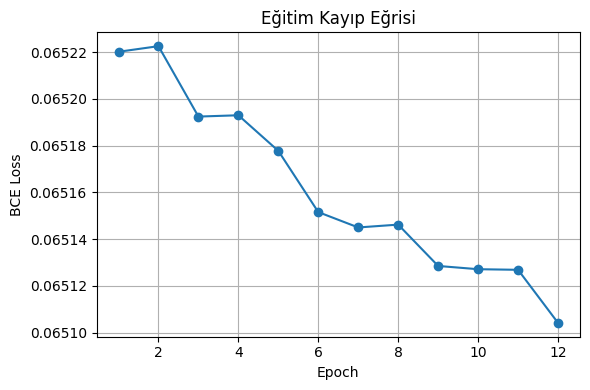

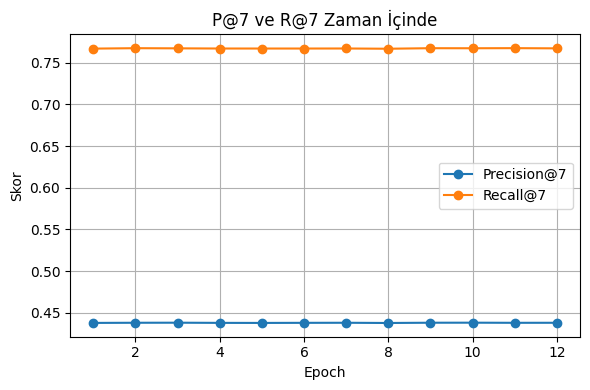

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist_loss)+1)

# 1) BCE Loss eğrisi
plt.figure(figsize=(6,4))
plt.plot(epochs, hist_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title('Eğitim Kayıp Eğrisi')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Precision@7 & Recall@7 eğrileri
plt.figure(figsize=(6,4))
plt.plot(epochs, hist_p7, marker='o', label='Precision@7')
plt.plot(epochs, hist_r7, marker='o', label='Recall@7')
plt.xlabel('Epoch')
plt.ylabel('Skor')
plt.title('P@7 ve R@7 Zaman İçinde')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 7.Hücre

In [ ]:
import joblib
torch.save(net.state_dict(), '/content/drive/MyDrive/data/item_net.pt')
joblib.dump(le_tier,  '/content/drive/MyDrive/data/le_tier.pkl')
joblib.dump(le_champ, '/content/drive/MyDrive/data/le_champ.pkl')
joblib.dump(le_pos,   '/content/drive/MyDrive/data/le_pos.pkl')
joblib.dump(mlb,      '/content/drive/MyDrive/data/item_mlb.pkl')

['/content/drive/MyDrive/data/item_mlb.pkl']

### 8.Hücre

In [ ]:
import torch, joblib, numpy as np

SAVE_DIR = "/content/drive/MyDrive/data/"
device    = "cuda" if torch.cuda.is_available() else "cpu"

mlb_item      = joblib.load(SAVE_DIR + "item_mlb.pkl")
le_tier_item  = joblib.load(SAVE_DIR + "le_tier.pkl")
le_pos_item   = joblib.load(SAVE_DIR + "le_pos.pkl")
le_champ_item = joblib.load(SAVE_DIR + "le_champ.pkl")

net_item = ItemNet(len(le_tier_item.classes_),
                   len(le_champ_item.classes_),
                   len(le_pos_item.classes_),
                   len(mlb_item.classes_)).to(device)

net_item.load_state_dict(torch.load(SAVE_DIR + "item_net.pt",
                                    map_location=device))
net_item.eval()
allowed_items = list(mlb_item.classes_)

tier_to_id = {
    "iron":1,"bronze":2,"silver":3,"gold":4,
    "platinum":5,"emerald":6, "diamond":7
}

pos_to_id = {
    "TOP":1, "JUNGLE":2,"MIDDLE":3, "BOTTOM":4, "UTILITY":5
}

champ_to_id = {
    "Aatrox": 266, "Ahri": 103, "Akali": 84, "Akshan": 166, "Alistar": 12, "Ambessa": 799, "Amumu": 32, "Anivia": 34,
    "Annie": 1, "Aphelios": 523, "Ashe": 22, "AurelionSol": 136, "Aurora": 893, "Azir": 268, "Bard": 432, "Belveth": 200,
    "Blitzcrank": 53, "Brand": 63, "Braum": 201, "Briar": 233, "Caitlyn": 51, "Camille": 164, "Cassiopeia": 69,
    "Chogath": 31, "Corki": 42, "Darius": 122, "Diana": 131, "Draven": 119, "DrMundo": 36, "Ekko": 245, "Elise": 60,
    "Evelynn": 28, "Ezreal": 81, "FiddleSticks": 9, "Fiora": 114, "Fizz": 105, "Galio": 3, "Gangplank": 41, "Garen": 86,
    "Gnar": 150, "Gragas": 79, "Graves": 104, "Gwen": 887, "Hecarim": 120, "Heimerdinger": 74, "Hwei": 910,
    "Illaoi": 420, "Irelia": 39, "Ivern": 427, "Janna": 40, "JarvanIV": 59, "Jax": 24, "Jayce": 126, "Jhin": 202,
    "Jinx": 222, "Kaisa": 145, "Kalista": 429, "Karma": 43, "Karthus": 30, "Kassadin": 38, "Katarina": 55,
    "Kayle": 10, "Kayn": 141, "Kennen": 85, "Khazix": 121, "Kindred": 203, "Kled": 240, "KogMaw": 96, "KSante": 897,
    "Leblanc": 7, "LeeSin": 64, "Leona": 89, "Lillia": 876, "Lissandra": 127, "Lucian": 236, "Lulu": 117, "Lux": 99,
    "Malphite": 54, "Malzahar": 90, "Maokai": 57, "MasterYi": 11, "Mel": 800, "Milio": 902, "MissFortune": 21,
    "MonkeyKing": 62, "Mordekaiser": 82, "Morgana": 25, "Naafiri": 950, "Nami": 267, "Nasus": 75, "Nautilus": 111,
    "Neeko": 518, "Nidalee": 76, "Nilah": 895, "Nocturne": 56, "Nunu": 20, "Olaf": 2, "Orianna": 61, "Ornn": 516,
    "Pantheon": 80, "Poppy": 78, "Pyke": 555, "Qiyana": 246, "Quinn": 133, "Rakan": 497, "Rammus": 33, "RekSai": 421,
    "Rell": 526, "Renata": 888, "Renekton": 58, "Rengar": 107, "Riven": 92, "Rumble": 68, "Ryze": 13, "Samira": 360,
    "Sejuani": 113, "Senna": 235, "Seraphine": 147, "Sett": 875, "Shaco": 35, "Shen": 98, "Shyvana": 102,
    "Singed": 27, "Sion": 14, "Sivir": 15, "Skarner": 72, "Smolder": 901, "Sona": 37, "Soraka": 16, "Swain": 50,
    "Sylas": 517, "Syndra": 134, "TahmKench": 223, "Taliyah": 163, "Talon": 91, "Taric": 44, "Teemo": 17,
    "Thresh": 412, "Tristana": 18, "Trundle": 48, "Tryndamere": 23, "TwistedFate": 4, "Twitch": 29, "Udyr": 77,
    "Urgot": 6, "Varus": 110, "Vayne": 67, "Veigar": 45, "Velkoz": 161, "Vex": 711, "Vi": 254, "Viego": 234,
    "Viktor": 112, "Vladimir": 8, "Volibear": 106, "Warwick": 19, "Xayah": 498, "Xerath": 101, "XinZhao": 5,
    "Yasuo": 157, "Yone": 777, "Yorick": 83, "Yuumi": 350, "Zac": 154, "Zed": 238, "Zeri": 221, "Ziggs": 115,
    "Zilean": 26, "Zoe": 142, "Zyra": 143, "None": 0
}

def recommend_items(tier:str, champ:str, lane:str, k:int=7):
    t_id = tier_to_id[tier.lower()]
    p_id = pos_to_id[lane.upper()]
    c_id = champ_to_id[champ]

    x_enc = torch.tensor([[ le_tier_item.transform([t_id])[0],
                            le_champ_item.transform([c_id])[0],
                            le_pos_item.transform([p_id])[0] ]],
                         dtype=torch.long, device=device)

    with torch.no_grad():
        probs = torch.sigmoid(net_item(x_enc)).cpu().numpy()[0]

    idx_sorted = probs.argsort()[::-1]
    chosen = []
    for idx in idx_sorted:
        itm = int(allowed_items[idx])
        if itm not in chosen:
            chosen.append(itm)
        if len(chosen) == k:
            break
    return chosen

print("Örnek (diamond, Ashe, BOTTOM) →", recommend_items("gold", "Ashe", "BOTTOM"))
print("Örnek (diamond, Lucian, BOTTOM) →", recommend_items("gold", "Lucian", "BOTTOM"))

Örnek (diamond, Ashe, BOTTOM) → [3006, 6672, 3046, 3153, 3031, 3032, 3085]
Örnek (diamond, Lucian, BOTTOM) → [3508, 3031, 6675, 3158, 3036, 6676, 3006]


## Perk Tahmini

### 1.Hücre

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

CSV_PATH = '/content/drive/MyDrive/data/Perk_Training_Data_Filtered.csv'
df = pd.read_csv(CSV_PATH)

# perk1‒perk6
perk_cols = [f'perk{i}' for i in range(1, 7)]

label_lists = df[perk_cols].apply(
    lambda r: [int(x) for x in r if x != 0 and not pd.isna(x)],
    axis=1
)

allowed_perks = sorted({p for lst in label_lists for p in lst})

mlb = MultiLabelBinarizer(classes=allowed_perks)
Y   = mlb.fit_transform(label_lists).astype('float32')

print("Y shape:", Y.shape, "| toplam benzersiz perk:", len(allowed_perks))


Y shape: (717661, 71) | toplam benzersiz perk: 71


### 2.Hücre

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_tier  = LabelEncoder().fit(df['tier'])
le_pos   = LabelEncoder().fit(df['individualPosition'])
le_champ = LabelEncoder().fit(df['championName'])

X = pd.DataFrame({
    'tier' : le_tier.transform(df['tier']),
    'champ': le_champ.transform(df['championName']),
    'pos'  : le_pos.transform(df['individualPosition'])
}).values.astype('int64')

print("X shape:", X.shape)


X shape: (717661, 3)


### 3.Hücre

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# ---------  stratify vektörü ---------
label_counts = Y.sum(axis=1)
strata       = label_counts.clip(0, 3).astype(int)   # 0,1,2,3+  (4’ler 3’e inmiş oldu)

# ---------  Sınıf dağılımını incele ---------
counts = np.bincount(strata)
print("Sınıf dağılımı:", counts)        # örn: [1234 987 456 1]

rare_classes = np.where(counts < 2)[0]  # tekillikleri bul
if len(rare_classes):
    print("Tekil kalan sınıflar:", rare_classes, "→ satırlar atılacak.")
    keep_mask = ~np.isin(strata, rare_classes)
    X_filt, Y_filt = X[keep_mask], Y[keep_mask]
    strata_filt    = strata[keep_mask]
else:
    X_filt, Y_filt, strata_filt = X, Y, strata

# ---------  Veri setini böl ---------
X_train, X_val, Y_train, Y_val = train_test_split(
    X_filt, Y_filt, test_size=0.10, random_state=42, stratify=strata_filt
)

# ---------  Torch Dataset / DataLoader ---------
class PerkDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

train_dl = DataLoader(PerkDataset(X_train, Y_train), batch_size=512,
                      shuffle=True,  drop_last=True)
val_dl   = DataLoader(PerkDataset(X_val,   Y_val), batch_size=512,
                      shuffle=False, drop_last=False)

print("Train batches:", len(train_dl), "| Val batches:", len(val_dl))


Sınıf dağılımı: [     1      0      0 717660]
Tekil kalan sınıflar: [0 1 2] → satırlar atılacak.
Train batches: 1261 | Val batches: 141


### 4.Hücre

In [ ]:
import torch.nn as nn

class PerkNet(nn.Module):
    def __init__(self, n_tier, n_champ, n_pos, n_perks):
        super().__init__()
        self.emb_tier  = nn.Embedding(n_tier, 4)
        self.emb_champ = nn.Embedding(n_champ, 32)
        self.emb_pos   = nn.Embedding(n_pos, 4)
        self.ff = nn.Sequential(
            nn.Linear(40, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, n_perks)
        )
    def forward(self, x):
        t = self.emb_tier(x[:,0])
        c = self.emb_champ(x[:,1])
        p = self.emb_pos(x[:,2])
        z = torch.cat([t, c, p], dim=1)
        return self.ff(z)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = PerkNet(len(le_tier.classes_),
              len(le_champ.classes_),
              len(le_pos.classes_),
              len(allowed_perks)).to(device)


### 5.Hücre

In [ ]:
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score

criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(net.parameters(), lr=1e-3)

def pr_re_at_k(probs, true, k=6):
    topk = probs.argsort(axis=1)[:, -k:]
    hits = [(true[i, idx] == 1).sum() for i, idx in enumerate(topk)]
    prec = np.mean([h / k for h in hits])
    rec  = np.mean([h / true[i].sum() if true[i].sum()>0 else 0 for i,h in enumerate(hits)])
    return prec, rec

hist_loss, hist_p6, hist_r6 = [], [], []

for epoch in range(12):
    net.train(); tot = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = net(xb)
        loss = criterion(out, yb)
        loss.backward(); opt.step()
        tot += loss.item()

    net.eval(); all_probs, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            logits = net(xb)
            all_probs.append(torch.sigmoid(logits).cpu().numpy())
            all_true.append(yb.numpy())
    probs = np.vstack(all_probs)
    true  = np.vstack(all_true)
    p6, r6 = pr_re_at_k(probs, true, k=6)

    hist_loss.append(tot/len(train_dl))
    hist_p6.append(p6)
    hist_r6.append(r6)

    print(f"Epoch {epoch+1:02d} | BCE {tot/len(train_dl):.4f} | "
          f"P@6 {p6:.3f}  R@6 {r6:.3f}")


Epoch 01 | BCE 0.1526 | P@6 0.720  R@6 0.721
Epoch 02 | BCE 0.1261 | P@6 0.724  R@6 0.724
Epoch 03 | BCE 0.1235 | P@6 0.725  R@6 0.725
Epoch 04 | BCE 0.1223 | P@6 0.726  R@6 0.726
Epoch 05 | BCE 0.1216 | P@6 0.726  R@6 0.726
Epoch 06 | BCE 0.1211 | P@6 0.726  R@6 0.726
Epoch 07 | BCE 0.1208 | P@6 0.727  R@6 0.727
Epoch 08 | BCE 0.1205 | P@6 0.727  R@6 0.727
Epoch 09 | BCE 0.1202 | P@6 0.727  R@6 0.727
Epoch 10 | BCE 0.1201 | P@6 0.727  R@6 0.727
Epoch 11 | BCE 0.1199 | P@6 0.727  R@6 0.727
Epoch 12 | BCE 0.1198 | P@6 0.727  R@6 0.727


### 6.Hücre

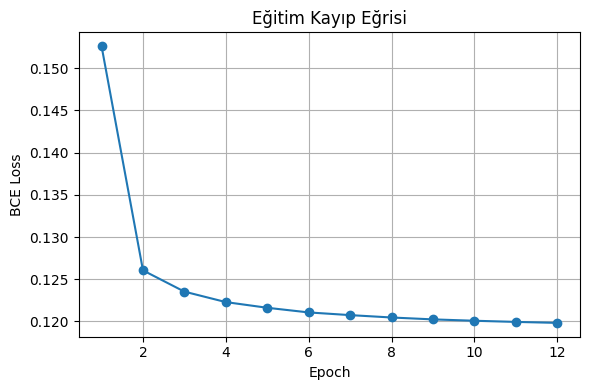

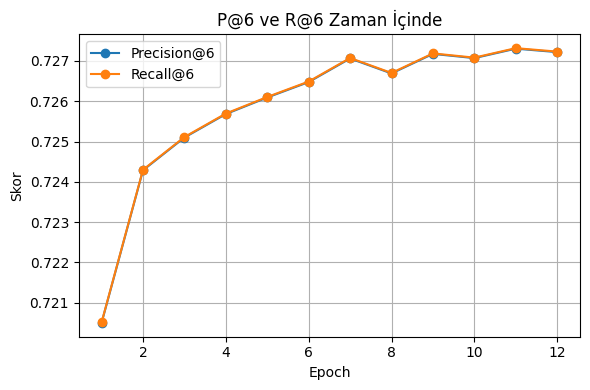

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist_loss)+1)

# BCE Loss
plt.figure(figsize=(6,4))
plt.plot(epochs, hist_loss, marker='o')
plt.xlabel('Epoch'); plt.ylabel('BCE Loss')
plt.title('Eğitim Kayıp Eğrisi'); plt.grid(); plt.tight_layout()
plt.show()

# Precision@6 & Recall@6
plt.figure(figsize=(6,4))
plt.plot(epochs, hist_p6, marker='o', label='Precision@6')
plt.plot(epochs, hist_r6, marker='o', label='Recall@6')
plt.xlabel('Epoch'); plt.ylabel('Skor')
plt.title('P@6 ve R@6 Zaman İçinde'); plt.legend(); plt.grid(); plt.tight_layout()
plt.show()


### 7.Hücre

In [ ]:
import joblib, os
SAVE_DIR = '/content/drive/MyDrive/data/'
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(net.state_dict(), SAVE_DIR + 'perk_net.pt')
joblib.dump(le_tier,  SAVE_DIR + 'le_tier_perk.pkl')
joblib.dump(le_champ, SAVE_DIR + 'le_champ_perk.pkl')
joblib.dump(le_pos,   SAVE_DIR + 'le_pos_perk.pkl')
joblib.dump(mlb,      SAVE_DIR + 'perk_mlb.pkl')


['/content/drive/MyDrive/data/perk_mlb.pkl']

### 8.Hücre

In [ ]:
import torch, joblib, numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
mlb_perk      = joblib.load(SAVE_DIR + 'perk_mlb.pkl')
le_tier_perk  = joblib.load(SAVE_DIR + 'le_tier_perk.pkl')
le_pos_perk   = joblib.load(SAVE_DIR + 'le_pos_perk.pkl')
le_champ_perk = joblib.load(SAVE_DIR + 'le_champ_perk.pkl')

net_perk = PerkNet(len(le_tier_perk.classes_),
                   len(le_champ_perk.classes_),
                   len(le_pos_perk.classes_),
                   len(mlb_perk.classes_)).to(device)
net_perk.load_state_dict(torch.load(SAVE_DIR + "perk_net.pt",
                                    map_location=device))
net_perk.eval()
allowed_perks = list(mlb_perk.classes_)

def recommend_perks(tier:str, champ:str, lane:str, k:int=6):
    t_id = tier_to_id[tier.lower()]
    p_id = pos_to_id[lane.upper()]
    c_id = champ_to_id[champ]

    x_enc = torch.tensor([[ le_tier_perk.transform([t_id])[0],
                            le_champ_perk.transform([c_id])[0],
                            le_pos_perk.transform([p_id])[0] ]],
                         dtype=torch.long, device=device)

    with torch.no_grad():
        probs = torch.sigmoid(net_perk(x_enc)).cpu().numpy()[0]

    idx_sorted, chosen = probs.argsort()[::-1], []
    for idx in idx_sorted:
        pk = int(allowed_perks[idx])
        if pk not in chosen:
            chosen.append(pk)
        if len(chosen) == k:
            break
    return chosen

print(recommend_perks("diamond", "Ashe", "BOTTOM"))


[8410, 8008, 8009, 8017, 8345, 9104]


# Birleştirilmiş Deneme

In [ ]:
item_map = {
    0:"none", 1001: "Boots", 1004: "Faerie Charm", 1006: "Rejuvenation Bead", 1011: "Giant's Belt", 1018: "Cloak of Agility", 1026: "Blasting Wand", 1027: "Sapphire Crystal",
    1028: "Ruby Crystal", 1029: "Cloth Armor", 1031: "Chain Vest", 1033: "Null-Magic Mantle", 1035: "Emberknife", 1036: "Long Sword", 1037: "Pickaxe", 1038: "B. F. Sword",
    1039: "Hailblade", 1040: "Obsidian Edge", 1042: "Dagger", 1043: "Recurve Bow", 1052: "Amplifying Tome", 1053: "Vampiric Scepter", 1054: "Doran's Shield",
    1055: "Doran's Blade", 1056: "Doran's Ring", 1057: "Negatron Cloak", 1058: "Needlessly Large Rod", 1082: "Dark Seal", 1083: "Cull", 1101: "Scorchclaw Pup",
    1102: "Gustwalker Hatchling", 1103: "Mosstomper Seedling", 1104: "Eye of the Herald", 1105: "Mosstomper Seedling", 1106: "Gustwalker Hatchling",
    1107: "Scorchclaw Pup", 126697: "Hubris", 1500: "Penetrating Bullets", 1501: "Fortification", 1502: "Reinforced Armor", 1503: "Warden's Eye", 1504: "Vanguard",
    1506: "Reinforced Armor", 1507: "Overcharged", 1508: "Anti-tower Socks", 1509: "Gusto", 1510: "Phreakish Gusto", 1511: "Super Mech Armor",
    1512: "Super Mech Power Field", 1515: "Turret Plating", 1516: "Structure Bounty", 1517: "Structure Bounty", 1518: "Structure Bounty", 1519: "Structure Bounty",
    1520: "OvererchargedHA", 1521: "Fortification", 1522: "Tower Power-Up", 1523: "Overcharged", 2003: "Health Potion", 2010: "Total Biscuit of Everlasting Will",
    2015: "Kircheis Shard", 2019: "Steel Sigil", 2020: "The Brutalizer", 2021: "Tunneler", 2022: "Glowing Mote", 2031: "Refillable Potion", 2033: "Corrupting Potion",
    2049: "Guardian's Amulet", 2050: "Guardian's Shroud", 2051: "Guardian's Horn", 2052: "Poro-Snax", 2055: "Control Ward", 2056: "Stealth Ward",
    2065: "Shurelya's Battlesong", 2138: "Elixir of Iron", 2139: "Elixir of Sorcery", 2140: "Elixir of Wrath", 2141: "Cappa Juice", 2142: "Juice of Power",
    2143: "Juice of Vitality", 2144: "Juice of Haste", 2145: "Lucky Dice", 2146: "Enhanced Lucky Dice", 2150: "Elixir of Skill", 2151: "Elixir of Avarice",
    2152: "Elixir of Force", 220000: "Stat Bonus", 220001: "Legendary Fighter Item", 220002: "Legendary Marksman Item", 220003: "Legendary Assassin Item", 2403: "Minion Dematerializer",
    2420: "Seeker's Armguard", 2421: "Shattered Armguard", 2422: "Slightly Magical Footwear", 2501: "Overlord's Bloodmail", 2502: "Unending Despair", 2503: "Blackfire Torch",
    2504: "Kaenic Rookern", 2508: "Fated Ashes", 3001: "Evenshroud", 3002: "Trailblazer", 3003: "Archangel's Staff", 3004: "Manamune", 3005: "Ghostcrawlers",
    3006: "Berserker's Greaves", 3009: "Boots of Swiftness", 3010: "Symbiotic Soles", 3011: "Chemtech Putrifier", 3012: "Chalice of Blessing", 3013: "Synchronized Souls",
    3020: "Sorcerer's Shoes", 3023: "Lifewell Pendant", 3024: "Glacial Buckler", 3026: "Guardian Angel", 3031: "Infinity Edge", 3032: "Yun Tal Wildarrows",
    3033: "Mortal Reminder", 3035: "Last Whisper", 3036: "Lord Dominik's Regards", 3039: "Atma's Reckoning", 3040: "Seraph's Embrace", 3041: "Mejai's Soulstealer",
    3042: "Muramana", 3044: "Phage", 3046: "Phantom Dancer", 3047: "Plated Steelcaps", 3050: "Zeke's Convergence", 3051: "Hearthbound Axe", 3053: "Sterak's Gage",
    3057: "Sheen", 3065: "Spirit Visage", 3066: "Winged Moonplate", 3067: "Kindlegem", 3068: "Sunfire Aegis", 3070: "Tear of the Goddess", 3071: "Black Cleaver",
    3072: "Bloodthirster", 3073: "Experimental Hexplate", 3074: "Ravenous Hydra", 3075: "Thornmail", 3076: "Bramble Vest", 3077: "Tiamat", 3078: "Trinity Force",
    3082: "Warden's Mail", 3083: "Warmog's Armor", 3084: "Heartsteel", 3085: "Runaan's Hurricane", 3086: "Zeal", 3087: "Statikk Shiv", 3089: "Rabadon's Deathcap",
    3091: "Wit's End", 3094: "Rapid Firecannon", 3095: "Stormrazor", 3100: "Lich Bane", 3102: "Banshee's Veil", 3105: "Aegis of the Legion", 3107: "Redemption",
    3108: "Fiendish Codex", 3109: "Knight's Vow", 3110: "Frozen Heart", 3111: "Mercury's Treads", 3112: "Guardian's Orb", 3113: "Aether Wisp", 3114: "Forbidden Idol",
    3115: "Nashor's Tooth", 3116: "Rylai's Crystal Scepter", 3117: "Mobility Boots", 3118: "Malignance", 3119: "Winter's Approach", 3121: "Fimbulwinter",
    3123: "Executioner's Calling", 3124: "Guinsoo's Rageblade", 3128: "Deathfire Grasp", 3131: "Sword of the Divine", 3133: "Caulfield's Warhammer", 3134: "Serrated Dirk",
    3135: "Void Staff", 3137: "Cryptbloom", 3139: "Mercurial Scimitar", 3140: "Quicksilver Sash", 3142: "Youmuu's Ghostblade", 3143: "Randuin's Omen", 3144: "Scout's Slingshot",
    3145: "Hextech Alternator", 3146: "Hextech Gunblade", 3147: "Haunting Guise", 3152: "Hextech Rocketbelt", 3153: "Blade of The Ruined King", 3155: "Hexdrinker",
    3156: "Maw of Malmortius", 3157: "Zhonya's Hourglass", 3158: "Ionian Boots of Lucidity", 3161: "Spear of Shojin", 3165: "Morellonomicon", 3170: "Swiftmarch",
    3171: "Crimson Lucidity", 3172: "Gunmetal Greaves", 3173: "Chainlaced Crushers", 3174: "Armored Advance", 3175: "Spellslinger's Shoes", 3176: "Forever Forward",
    3177: "Guardian's Blade", 3179: "Umbral Glaive", 3181: "Hullbreaker", 3184: "Guardian's Hammer", 3190: "Locket of the Iron Solari", 3193: "Gargoyle Stoneplate",
    3302: "Terminus", 3330: "Scarecrow Effigy", 3340: "Stealth Ward", 3348: "Arcane Sweeper", 3349: "Lucent Singularity", 3363: "Farsight Alteration", 3364: "Oracle Lens",
    3398: "Small Party Favor", 3399: "Party Favor", 3400: "Your Cut", 3430: "Rite Of Ruin", 3504: "Ardent Censer", 3508: "Essence Reaver", 3513: "Eye of the Herald",
    3599: "Kalista's Black Spear", 3600: "Kalista's Black Spear", 3742: "Dead Man's Plate", 3748: "Titanic Hydra", 3801: "Crystalline Bracer", 3802: "Lost Chapter",
    3803: "Catalyst of Aeons", 3814: "Edge of Night", 3850: "Spellthief's Edge", 3851: "Frostfang", 3853: "Shard of True Ice", 3854: "Steel Shoulderguards",
    3855: "Runesteel Spaulders", 3857: "Pauldrons of Whiterock", 3858: "Relic Shield", 3859: "Targon's Buckler", 3860: "Bulwark of the Mountain", 3862: "Spectral Sickle",
    3863: "Harrowing Crescent", 3864: "Black Mist Scythe", 3865: "World Atlas", 3866: "Runic Compass", 3867: "Bounty of Worlds", 3869: "Celestial Opposition",
    3870: "Dream Maker", 3871: "Zaz'Zak's Realmspike", 3876: "Solstice Sleigh", 3877: "Bloodsong", 3916: "Oblivion Orb", 4003: "Lifeline", 4004: "Spectral Cutlass",
    4005: "Imperial Mandate", 4010: "Bloodletter's Curse", 4011: "Sword of Blossoming Dawn", 4012: "Sin Eater", 4013: "Lightning Braid", 4014: "Frozen Mallet",
    4015: "Perplexity", 4016: "Wordless Promise", 4017: "Hellfire Hatchet", 4401: "Force of Nature", 4402: "Innervating Locket", 4403: "The Golden Spatula",
    4628: "Horizon Focus", 4629: "Cosmic Drive", 4630: "Blighting Jewel", 4632: "Verdant Barrier",
    4633: "Riftmaker", 4635: "Leeching Leer", 4636: "Night Harvester", 4637: "Demonic Embrace", 4638: "Watchful Wardstone", 4641: "Stirring Wardstone",
    4642: "Bandleglass Mirror", 4643: "Vigilant Wardstone", 4644: "Crown of the Shattered Queen", 4645: "Shadowflame", 4646: "Stormsurge", 6029: "Ironspike Whip",
    6035: "Silvermere Dawn", 6333: "Death's Dance", 6609: "Chempunk Chainsword", 6610: "Sundered Sky", 6616: "Staff of Flowing Water", 6617: "Moonstone Renewer",
    6620: "Echoes of Helia", 6621: "Dawncore", 6630: "Goredrinker", 6631: "Stridebreaker", 6632: "Divine Sunderer", 6653: "Liandry's Torment",
    6655: "Luden's Companion", 6656: "Everfrost", 6657: "Rod of Ages", 6660: "Bami's Cinder", 6662: "Iceborn Gauntlet", 6664: "Hollow Radiance",
    6665: "Jak'Sho, The Protean", 6667: "Radiant Virtue", 6670: "Noonquiver", 6671: "Galeforce", 6672: "Kraken Slayer", 6673: "Immortal Shieldbow",
    6675: "Navori Flickerblade", 6676: "The Collector", 6677: "Rageknife", 6690: "Rectrix", 6691: "Duskblade of Draktharr", 6692: "Eclipse", 6693: "Prowler's Claw",
    6694: "Serylda's Grudge", 6695: "Serpent's Fang", 6696: "Axiom Arc", 6697: "Hubris", 6698: "Profane Hydra", 6699: "Voltaic Cyclosword",
    6700: "Shield of the Rakkor", 6701: "Opportunity", 7050: "Gangplank Placeholder", 8001: "Anathema's Chains", 8010: "Bloodletter's Curse", 8020: "Abyssal Mask",
    9168: "Locked Weapon Slot", 9171: "Cyclonic Slicers", 9172: "YuumiBot", 9174: "Statikk Sword", 9175: "Lioness's Lament", 9176: "Gatling Bunny-Guns",
    9177: "Searing Shortbow", 9178: "The Annihilator", 9179: "Battle Bunny Crossbow", 9180: "UwU Blaster", 9181: "Vortex Glove", 9183: "Blade-o-rang",
    9184: "Bunny Mega-Blast", 9185: "Anti-Shark Sea Mine", 9187: "T.I.B.B.E.R.S", 9188: "Ani-Mines", 9189: "Final City Transit", 9190: "Echoing Batblades",
    9192: "Paw Print Poisoner", 9193: "Iceblast Armor", 9271: "Unceasing Cyclone", 9272: "YuumiBot_Final_FINAL", 9273: "Explosive Embrace", 9274: "Prumbis's Electrocarver",
    9275: "Enveloping Light", 9276: "Double Bun-Bun Barrage", 9277: "Evolved Embershot", 9278: "Animapocalypse", 9279: "Bunny Prime Ballista", 9280: "OwO Blaster",
    9281: "Tempest's Gauntlet", 9283: "Quad-o-rang", 9284: "Rapid Rabbit Raindown", 9285: "Neverending Mobstomper", 9287: "T.I.B.B.E.R.S (B.E.E.G Edition)",
    9288: "Jinx's Tri-Namite", 9289: "FC Limited Express", 9290: "Vayne's Chromablades", 9292: "Bearfoot Chem-Dispenser", 9293: "Deep Freeze", 9300: "Meow Meow",
    9301: "Shield Slam", 9302: "Sound Wave", 9303: "Pillory Swipe", 9304: "Steel Tempest", 9305: "Tentacle Slam", 9306: "Winged Dagger", 9307: "Guiding Hex",
    9308: "Bunny Hop", 9400: "Battle Cat Barrage", 9401: "Light of the Lion", 9402: "Anima Echo", 9403: "Savage Slice", 9404: "Wandering Storms", 9405: "Grizzly Smash",
    9406: "Lover's Ricochet", 9407: "Hopped-Up Hex", 9408: "Carrot Crash"
}

perk_map = {
    8010: "Conqueror", 8112: "Electrocute", 8128: "Dark Harvest", 9923: "Hail of Blades",
    8126: "Cheap Shot", 8139: "Taste of Blood", 8143: "Sudden Impact", 8137: "Sixth Sense",
    8140: "Grisly Mementos", 8141: "Deep Ward", 8135: "Treasure Hunter", 8105: "Relentless Hunter",
    8106: "Ultimate Hunter", 8305: "Glacial Augment", 8360: "Unsealed Spellbook", 8369: "First Strike",
    8306: "Hextech Flashtraption", 8304: "Magical Footwear", 8321: "Cash Back", 8313: "Triple Tonic",
    8352: "Time Warp Tonic", 8345: "Biscuit Delivery", 8347: "Cosmic Insight", 8410: "Approach Velocity",
    8316: "Jack Of All Trades", 8005: "Press the Attack", 8008: "Lethal Tempo", 8021: "Fleet Footwork",
    8010: "Conqueror", 9101: "Absorb Life", 9111: "Triumph", 8009: "Presence of Mind",
    9104: "Legend: Alacrity", 9105: "Legend: Haste", 9103: "Legend: Bloodline", 8014: "Coup de Grace",
    8017: "Cut Down", 8299: "Last Stand", 8437: "Grasp of the Undying", 8439: "Aftershock",
    8465: "Guardian", 8446: "Demolish", 8463: "Font of Life", 8401: "Shield Bash",
    8429: "Conditioning", 8444: "Second Wind", 8473: "Bone Plating", 8451: "Overgrowth",
    8453: "Revitalize", 8242: "Unflinching", 8214: "Summon Aery", 8229: "Arcane Comet",
    8230: "Phase Rush", 8224: "Axiom Arcanist", 8226: "Manaflow Band", 8275: "Nimbus Cloak",
    8210: "Transcendence", 8234: "Celerity", 8233: "Absolute Focus", 8237: "Scorch",
    8232: "Waterwalking", 8236: "Gathering Storm"
}

In [ ]:
def recommend_loadout_named(tier:str, champ:str, lane:str,
                            k_items:int=7, k_perks:int=6):
    item_ids = recommend_items(tier, champ, lane, k_items)
    perk_ids = recommend_perks(tier, champ, lane, k_perks)
    return {
        "items": item_ids,
        "item_names": [item_map.get(i, f"unknown_{i}") for i in item_ids],
        "perks": perk_ids,
        "perk_names": [perk_map.get(p, f"unknown_{p}") for p in perk_ids],
    }

# Örnek:
out = recommend_loadout_named("diamond", "Sylas", "MIDDLE")
print(out["item_names"])
print(out["perk_names"])


['Hextech Rocketbelt', "Sorcerer's Shoes", "Zhonya's Hourglass", 'Cosmic Drive', 'Rod of Ages', 'Riftmaker', 'Shadowflame']
['Presence of Mind', 'Legend: Haste', 'Electrocute', 'Second Wind', 'Last Stand', 'Conqueror']


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

# Gradio arayüzüne uygun seçenekler
tier_options = ["iron", "bronze", "silver", "gold", "platinum", "emerald", "diamond"]
lane_options = ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]
champion_options = sorted(champ_to_id.keys())  # alfabetik sıralı

# Ana tahmin fonksiyonu
def predict_loadout(tier, champ, lane):
    try:
        out = recommend_loadout_named(tier, champ, lane)
        items = "\n".join(out["item_names"])
        perks = "\n".join(out["perk_names"])
        return items, perks
    except Exception as e:
        return f"Hata: {str(e)}", ""

# Gradio Arayüzü
iface = gr.Interface(
    fn=predict_loadout,
    inputs=[
        gr.Dropdown(tier_options, label="Tier"),
        gr.Dropdown(champion_options, label="Champion"),
        gr.Dropdown(lane_options, label="Lane")
    ],
    outputs=[
        gr.Textbox(label="Tahmin Edilen Item'lar"),
        gr.Textbox(label="Tahmin Edilen Perk'ler")
    ],
    title="LoL Loadout Tahmin Aracı",
    description="Tier, champion ve lane bilgilerini girerek önerilen item ve perk listesini görüntüleyin."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1f26f78deda93f1575.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Görseller

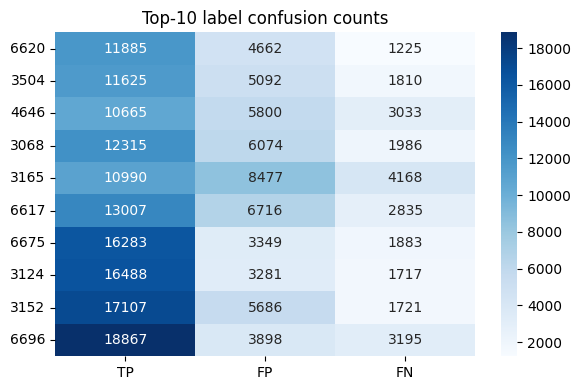

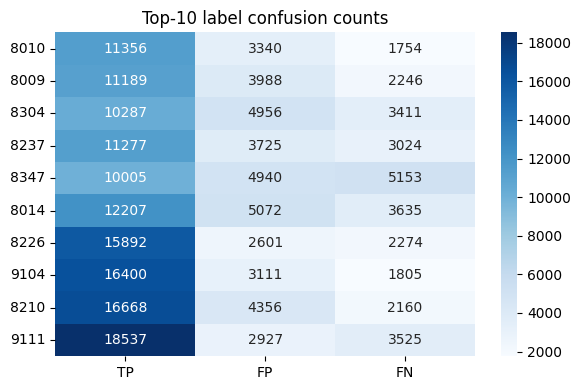

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import numpy as np

def topN_confmat(true, probs, classes, N=10, k=7):
    idx_topk = np.argsort(probs, axis=1)[:, -k:]
    preds = np.zeros_like(probs, dtype=int)
    for i,row in enumerate(idx_topk): preds[i, row] = 1
    freq = true.sum(axis=0)
    top_idx = np.argsort(freq)[-N:]
    cm = multilabel_confusion_matrix(true, preds)[top_idx]
    tp = cm[:,1,1]; fn = cm[:,1,0]; fp = cm[:,0,1]
    data = np.vstack([tp, fp, fn]).T
    labels = [str(classes[i]) for i in top_idx]
    plt.figure(figsize=(6,4))
    sns.heatmap(data, annot=True, fmt='d',
                xticklabels=['TP','FP','FN'], yticklabels=labels,
                cmap='Blues')
    plt.title('Top-%d label confusion counts' % N)
    plt.tight_layout(); plt.show()

topN_confmat(true_item, probs_item, allowed_items, N=10, k=7)
topN_confmat(np.vstack(all_t), np.vstack(all_p),
             allowed_perks, N=10, k=6)


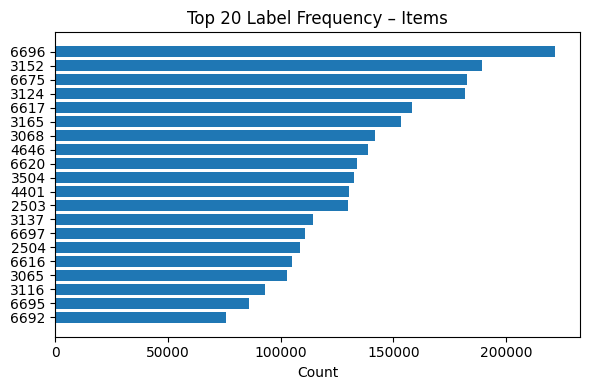

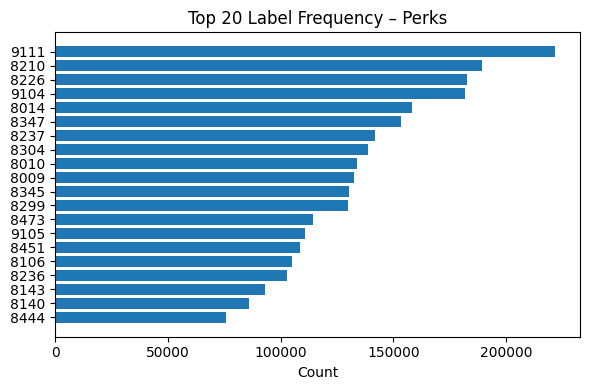

In [ ]:
def label_freq_bar(Y, classes, title, top=20):
    freq = Y.sum(axis=0)
    top_idx = np.argsort(freq)[-top:]
    labels = [str(classes[i]) for i in top_idx]
    plt.figure(figsize=(6,4))
    plt.barh(labels, freq[top_idx])
    plt.title(f'Top {top} Label Frequency – {title}')
    plt.xlabel('Count'); plt.tight_layout(); plt.show()

label_freq_bar(Y, allowed_items, 'Items')
label_freq_bar(Y, allowed_perks, 'Perks')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


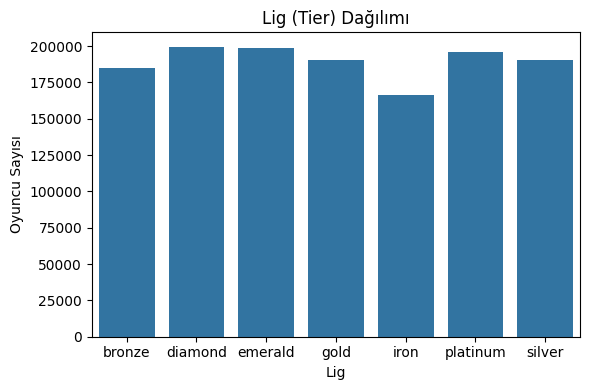

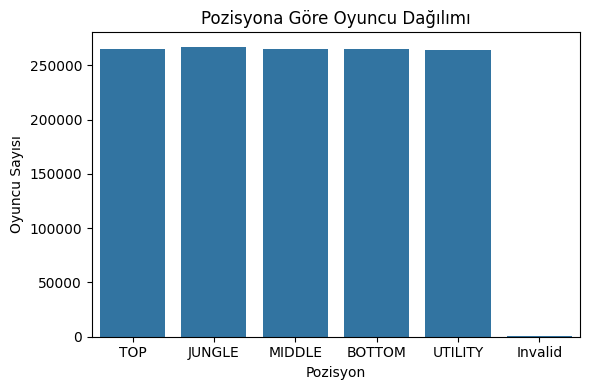

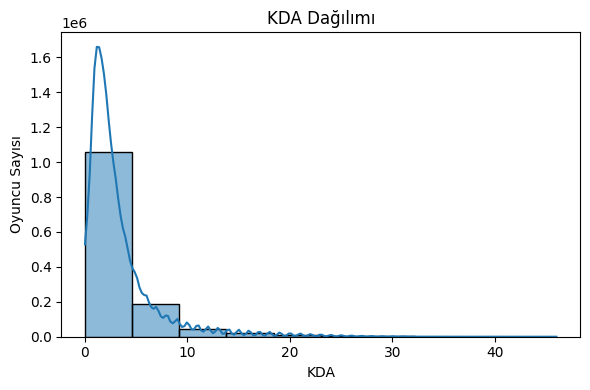

<ipython-input-4-5d774ea03135>:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


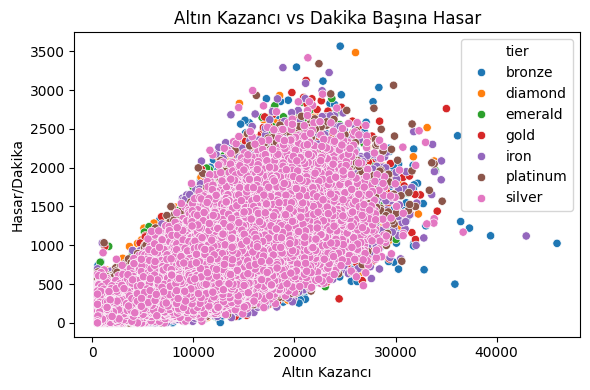

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from io import StringIO


df = pd.read_csv('/content/drive/MyDrive/data/ALL_TIERS_WITH_NAMES.csv')

plt.figure(figsize=(6, 4))
sns.countplot(x="tier", data=df)
plt.title("Lig (Tier) Dağılımı")
plt.xlabel("Lig")
plt.ylabel("Oyuncu Sayısı")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x="individualPosition", data=df)
plt.title("Pozisyona Göre Oyuncu Dağılımı")
plt.xlabel("Pozisyon")
plt.ylabel("Oyuncu Sayısı")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["kda"], bins=10, kde=True)
plt.title("KDA Dağılımı")
plt.xlabel("KDA")
plt.ylabel("Oyuncu Sayısı")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x="goldEarned", y="damagePerMinute", hue="tier", data=df)
plt.title("Altın Kazancı vs Dakika Başına Hasar")
plt.xlabel("Altın Kazancı")
plt.ylabel("Hasar/Dakika")
plt.tight_layout()
plt.show()
